In [22]:
import sys
import os

root_path = os.path.abspath('..')
if root_path not in sys.path:
    sys.path.insert(0, root_path)
    
functions_path = os.path.abspath('../Functions')
data_path = os.path.abspath('../Data')
algorithms_path = os.path.abspath('../Algorithms')

sys.path.append(functions_path)
sys.path.append(data_path)
sys.path.append(algorithms_path)

import numpy as np
import pandas as pd
import ruptures as rpt
import matplotlib.pyplot as plt
import time
from stumpy.floss import _rea
import random
import stumpy
from Functions.metrics import f_measure, covering

In [23]:
def binseg(ts, n_cps, cost_func="ar", offset=0.05):
    transformer = rpt.Binseg(model=cost_func, min_size=int(ts.shape[0] * offset)).fit(ts)
    return np.array(transformer.predict(n_bkps=n_cps)[:-1], dtype=np.int64)

In [24]:
def evaluate_binseg(dataset, ts, cps, **seg_kwargs):
    try:
        found_cps = binseg(ts, n_cps=len(cps), **seg_kwargs)
        # print("Found CPS:", found_cps)  # Debug print

        f1_score, percision, recall = f_measure({0: cps}, found_cps, margin=int(ts.shape[0] * .01), return_PR=True)
        covering_score = covering({0: cps}, found_cps, ts.shape[0])

        # print("F1 Score:", f1_score)  # Debug print
        # print("Covering Score:", covering_score)  # Debug print

        return dataset, cps, found_cps, np.round(f1_score, 3), np.round(covering_score, 3), percision, recall
    except Exception as e:
        print(f"An error occurred: {e}")
        raise

In [25]:
# Function to process, plot, and evaluate each PID
def process_plot_evaluate_pid(pid_df, pid, cost_func):
    rwrist_y = pid_df["RWrist_Y"].to_numpy()
    frame_peaks = pid_df["frame_peaks"].to_numpy()
    true_change_points = [i for i, peak in enumerate(frame_peaks) if peak == 1]

    start_time = time.time()
    n_cps = len(true_change_points)
    detected_cps = binseg(rwrist_y, n_cps, cost_func=cost_func)
    end_time = time.time()
    elapsed_time = end_time - start_time

    dataset, true_cps, detected_cps, f1_score, covering_score, percision, recall = evaluate_binseg(pid, rwrist_y, true_change_points, cost_func=cost_func)

    return dataset, true_cps, detected_cps, f1_score, covering_score, elapsed_time, percision, recall

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load CSV data
csv_file = '..//Data//Physio//OpenPose-RightWristWithoutSegmentation-full_df.csv'
df = pd.read_csv(csv_file)
cost_func = "ar"

total_time_binseg = 0
total_covering_binseg = 0
total_f1_binseg = 0
total_percision_binseg = 0
total_recall_binseg = 0
num_pids = 0

f1_scores_binseg = []
percision_scores_binseg = []
recall_scores_binseg = []
execution_times_binseg = []
coverages_binseg = []
evaluation_results_binseg = []

for pid, group in df.groupby("pid"):
    result = process_plot_evaluate_pid(group, pid, cost_func)
    evaluation_results_binseg.append(result)
    total_time_binseg += result[-3]
    total_covering_binseg += result[-4]
    total_f1_binseg += result[-5]
    total_percision_binseg += result[-2]
    total_recall_binseg += result[-1]
    num_pids += 1
    execution_times_binseg.append(result[-3])
    coverages_binseg.append(result[-4])
    f1_scores_binseg.append(result[-5])
    percision_scores_binseg.append(result[-2])
    recall_scores_binseg.append(result[-1])

average_time_binseg = total_time_binseg / num_pids
average_covering_binseg = total_covering_binseg / num_pids
average_precision_binseg = total_percision_binseg / num_pids
average_recall_binseg = total_recall_binseg / num_pids

average_f1_binseg = 2 * ((average_precision_binseg * average_recall_binseg) / (average_precision_binseg + average_recall_binseg))

# Print averages
print(f'Average Time: {average_time_binseg:.4f}s, Average Coverage: {average_covering_binseg:.6f}, Average F1 Score: {average_f1_binseg:.6f}, Average Precision: {average_precision_binseg:.6f}, Average Recall: {average_recall_binseg:.6f}')

Average Time: 0.0529s, Average Coverage: 0.556976, Average F1 Score: 0.319880, Average Precision: 0.312508, Average Recall: 0.327608


------------------------------------------------------------------------------------------------------------------------------------

# FLOSS

In [27]:
def floss(ts, sliding_window_size, window_size, n_cps, return_cac=False):
    mp = stumpy.stump(ts[:sliding_window_size], m=window_size)

    stream = stumpy.floss(
        mp,
        ts[:sliding_window_size],
        m=window_size,
        L=window_size
    )

    cac = np.full(ts.shape[0], fill_value=np.inf, dtype=np.float64)

    for dx, timepoint in zip(range(sliding_window_size, ts.shape[0]), ts[sliding_window_size:]):
        stream.update(timepoint)
        window_cac = stream.cac_1d_

        cac[max(0, dx - window_cac.shape[0]+1):dx+1] = np.min([
            cac[max(0, dx - window_cac.shape[0]+1):dx+1],
            window_cac[max(0, window_cac.shape[0]-dx-1):]
        ], axis=0)

    cps = _rea(cac, L=window_size, n_regimes=n_cps+1)

    if return_cac is True:
        return cac, cps

    return cps


In [28]:
def evaluate_floss(dataset, routine, subject, sensor, sample_rate, cps, activities, ts, **seg_kwargs):
    profile, found_cps = floss(ts, 20*sample_rate, sample_rate, n_cps=len(cps), return_cac=True, **seg_kwargs)

    f1_score1, percision, recall = f_measure({0: cps}, found_cps, margin=int(ts.shape[0] * .01), return_PR=True)
    f1_score = 2 * (percision * recall) / (percision + recall)
    covering_score = covering({0: cps}, found_cps, ts.shape[0])

    # print(f"{dataset}: F1-Score: {np.round(f1_score, 3)}, Covering-Score: {np.round(covering_score, 3)}")
    return dataset, cps, found_cps, np.round(f1_score, 3), np.round(covering_score, 3), profile, percision, recall

In [29]:
def process_plot_evaluate_pid_floss(pid_df, pid, window_size, routine, subject, sensor):
    ts = pid_df["RWrist_Y"].to_numpy()
    sample_rate = ts.shape[0] // 100
    frame_peaks = pid_df["frame_peaks"].to_numpy()
    true_change_points = [i for i, peak in enumerate(frame_peaks) if peak == 1]

    start_time = time.time()
    n_cps = len(true_change_points)
    detected_cps = floss(ts, 20*sample_rate, window_size, n_cps=n_cps, return_cac=False)
    end_time = time.time()
    elapsed_time = end_time - start_time

    # dataset, true_cps, detected_cps, f1_score, covering_score, _ = evaluate_floss(pid, routine, subject, sensor, sample_rate, true_change_points, [], ts)
    _, _, detected_cps, f1_score, covering_score, _, percision, recall = evaluate_floss(pid, routine, subject, sensor, sample_rate, true_change_points, [], ts)

    return pid, true_change_points, detected_cps, f1_score, covering_score, elapsed_time, percision, recall

In [30]:
# Load CSV data
csv_file = '..//Data//Physio//OpenPose-RightWristWithoutSegmentation-full_df.csv'
df = pd.read_csv(csv_file)

# Specify parameters for FLoSS
routine = 'Routine1'
subject = 'Subject1'
sensor = 'Accelerometer'
sample_rate = "Eight"  # Replace this with the actual computation if needed
window_size = 20

total_time_FLOSS = 0
total_covering_FLOSS = 0
total_f1_FLOSS = 0
total_percision_FLOSS = 0
total_recall_FLOSS = 0
num_pids = 0

f1_scores_FLOSS = []
percision_scores_FLOSS = []
recall_scores_FLOSS = []
execution_times_FLOSS = []
coverages_FLOSS = []

for pid, group in df.groupby("pid"):
    result = process_plot_evaluate_pid_floss(group, pid, window_size, routine, subject, sensor)

    total_time_FLOSS += result[-3]
    total_covering_FLOSS += result[-4]
    total_f1_FLOSS += result[-5]
    total_percision_FLOSS += result[-2]
    total_recall_FLOSS += result[-1]
    
    num_pids += 1
    execution_times_FLOSS.append(result[-3])
    coverages_FLOSS.append(result[-4])
    f1_scores_FLOSS.append(result[-5])
    percision_scores_FLOSS.append(result[-2])
    recall_scores_FLOSS.append(result[-1])

average_time_FLOSS = total_time_FLOSS / num_pids
average_covering_FLOSS = total_covering_FLOSS / num_pids
average_precision_FLOSS = total_percision_FLOSS / num_pids
average_recall_FLOSS = total_recall_FLOSS / num_pids
average_f1_FLOSS = 2 * ((average_precision_FLOSS * average_recall_FLOSS) / (average_precision_FLOSS + average_recall_FLOSS))

In [38]:
print(f'Average Time: {average_time_FLOSS:.4f}s, Average Coverage: {average_covering_FLOSS:.6f}, Average F1 Score: {average_f1_FLOSS:.6f}, Average Precision: {average_precision_FLOSS:.6f}, Average Recall: {average_recall_FLOSS:.6f}')

Average Time: 1.2892s, Average Coverage: 0.604600, Average F1 Score: 0.491812, Average Precision: 0.479771, Average Recall: 0.504472


------------------------------------------------------------------------------------------

# Random

In [31]:
# Function to process, plot, and evaluate each PID
def process_plot_evaluate_pid_random(pid_df, pid):
    rwrist_y = pid_df["RWrist_Y"].to_numpy()
    frame_peaks = pid_df["frame_peaks"].to_numpy()
    true_cps = [i for i, peak in enumerate(frame_peaks) if peak == 1]

    start_time = time.time()
    n_cps = len(true_cps)
    detected_cps = [random.randint(0, rwrist_y.shape[0]) for _ in range(n_cps)]
    end_time = time.time()
    elapsed_time = end_time - start_time
        
    f1_score, precision, recall = f_measure({1: true_cps}, detected_cps, margin=int(rwrist_y.shape[0] * 0.01), return_PR=True)
    covering_score = covering({1: true_cps}, detected_cps, rwrist_y.shape[0])

    dataset = pid_df.copy()

    return dataset, true_cps, detected_cps, f1_score, covering_score, elapsed_time, precision, recall

In [32]:
# Load CSV data
csv_file = '..//Data//Physio//OpenPose-RightWristWithoutSegmentation-full_df.csv'
df = pd.read_csv(csv_file)

total_time = 0
total_covering = 0
total_f1 = 0
total_precision = 0
total_recall = 0
num_pids = 0

f1_scores = []
precision_scores = []
recall_scores = []
execution_times = []
coverages = []
evaluation_results = []

for pid, group in df.groupby("pid"):
    result = process_plot_evaluate_pid_random(group, pid)
    evaluation_results.append(result)
    total_time += result[-3]
    total_covering += result[-4]
    total_f1 += result[-5]
    total_precision += result[-2]
    total_recall += result[-1]
    num_pids += 1
    execution_times.append(result[-3])
    coverages.append(result[-4])
    f1_scores.append(result[-5])
    precision_scores.append(result[-2])
    recall_scores.append(result[-1])

average_time = total_time / num_pids
average_covering = total_covering / num_pids
average_precision = total_precision / num_pids
average_recall = total_recall / num_pids
average_f1 = 2 * ((average_precision * average_recall) / (average_precision + average_recall))

In [40]:
print(f'Average Time: {average_time:.4f}s, Average Coverage: {average_covering:.6f}, Average F1 Score: {average_f1:.6f}, Average Precision: {average_precision:.6f}, Average Recall: {average_recall:.6f}')

Average Time: 0.0000s, Average Coverage: 0.472308, Average F1 Score: 0.262887, Average Precision: 0.257436, Average Recall: 0.268574


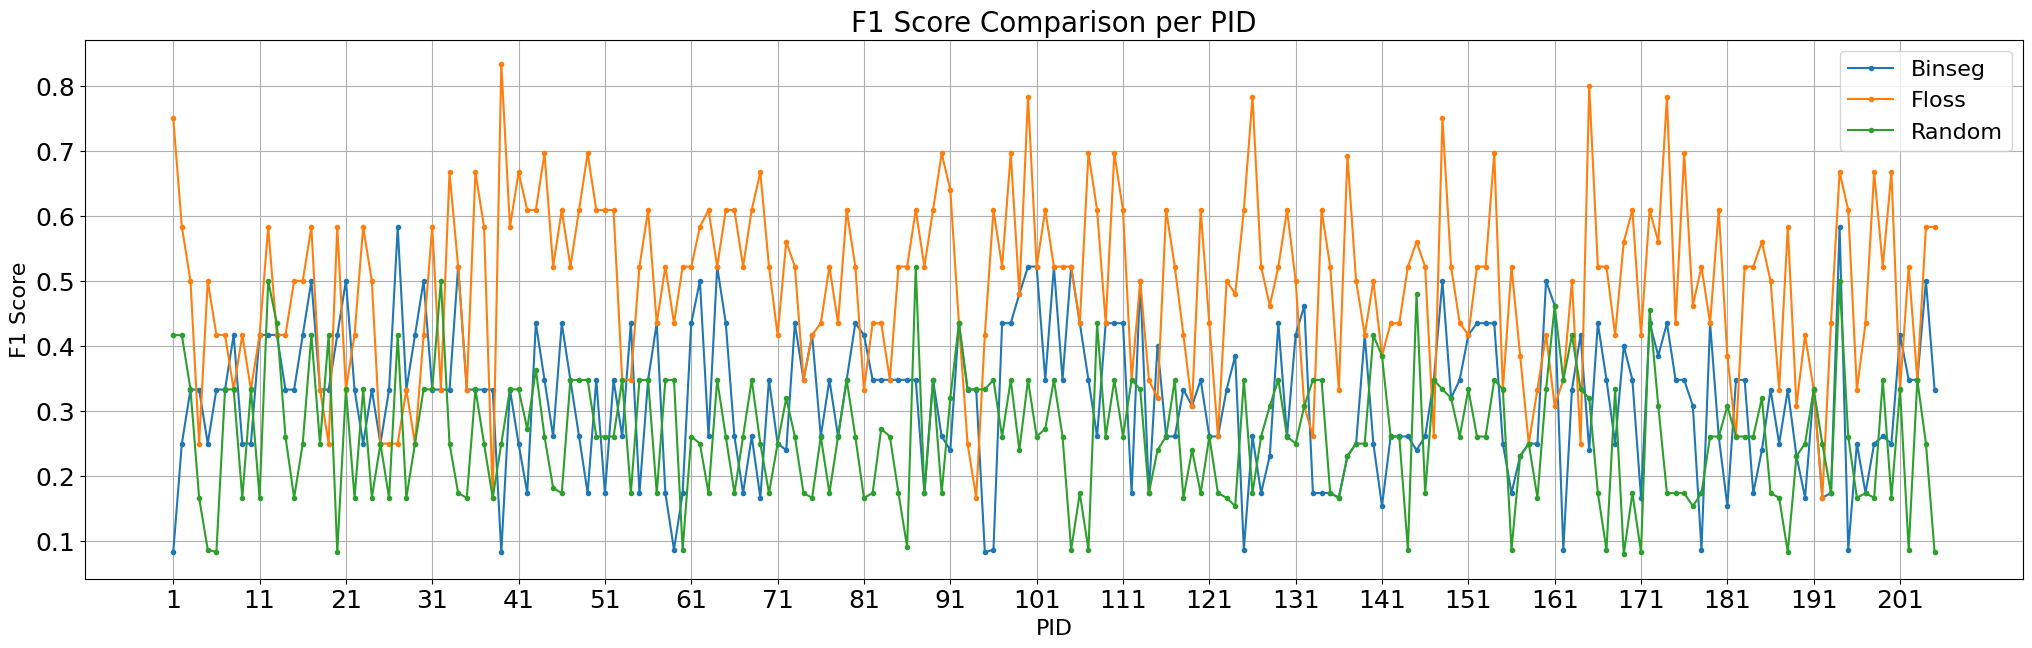

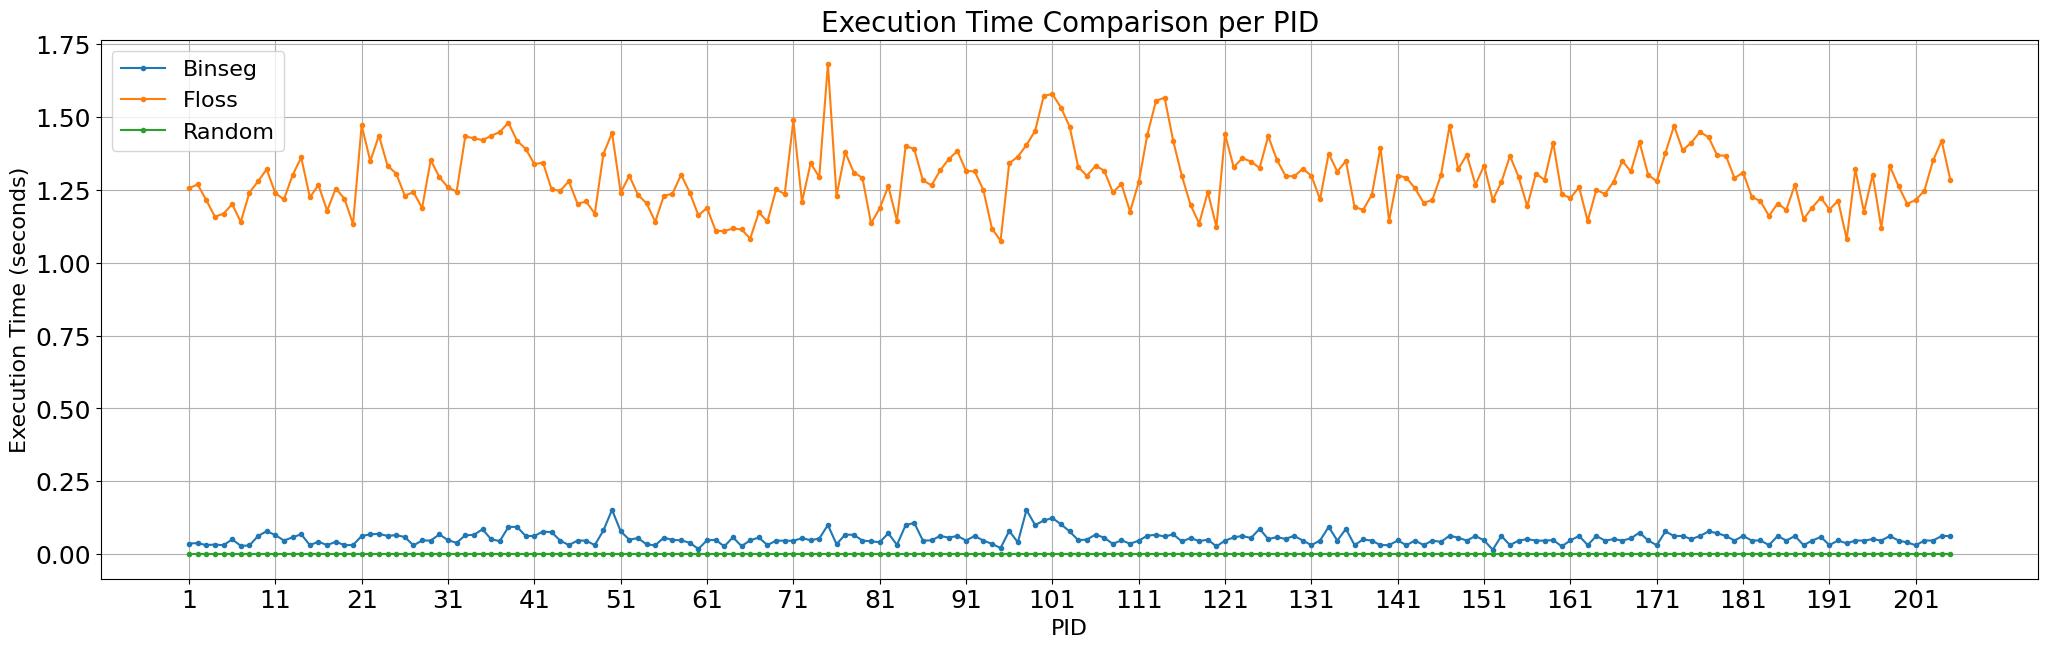

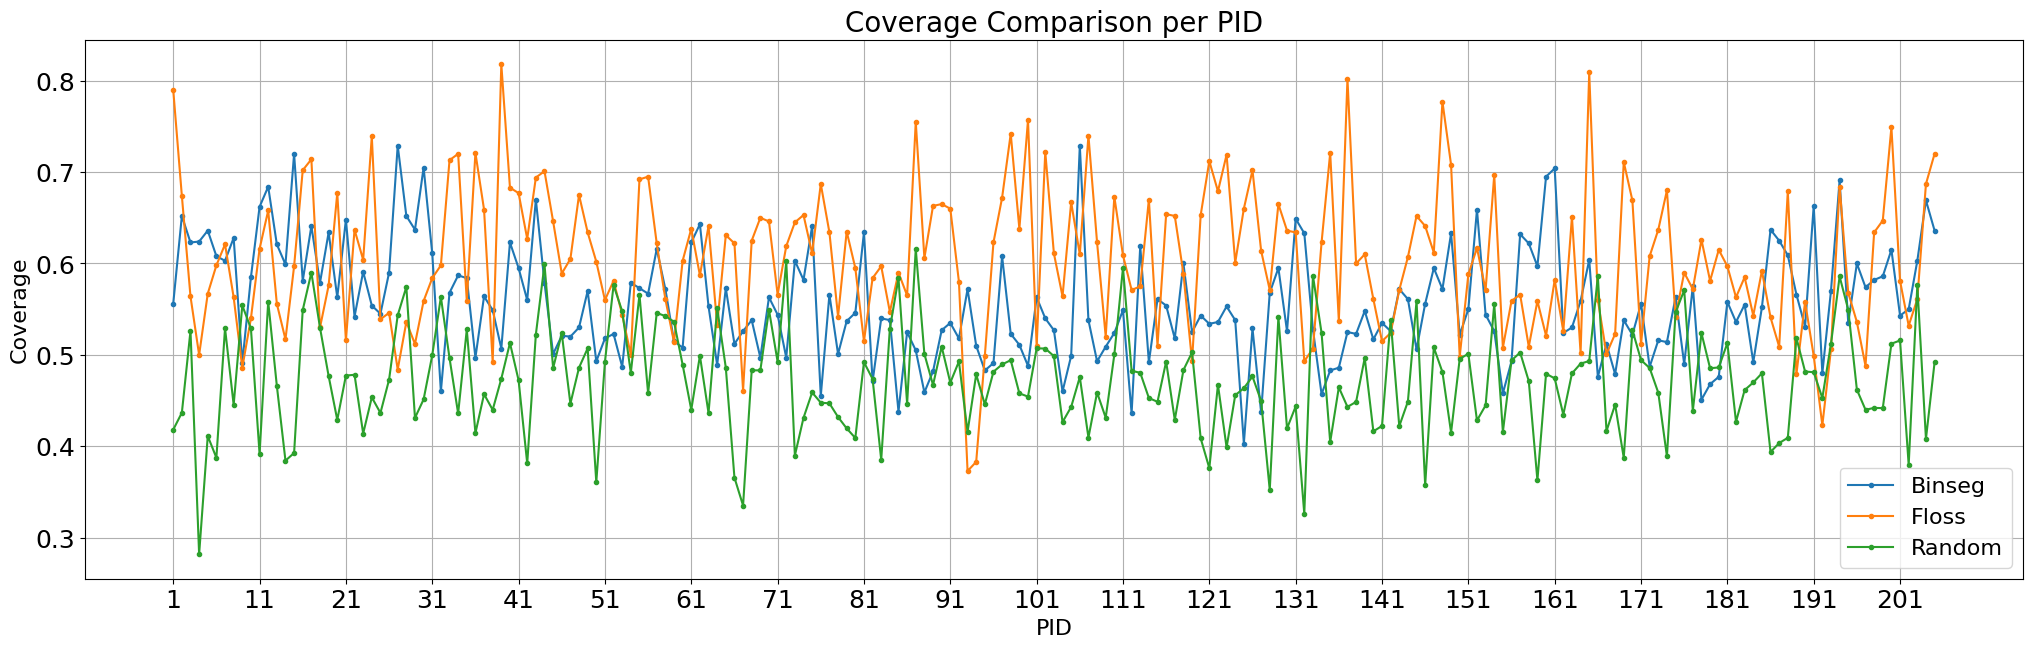

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def plot_algorithm_comparison(pids, data_binseg, data_floss, data_random, title, ylabel, filename):
    plt.figure(figsize=(25, 7))
    plt.plot(pids, data_binseg, marker='o', linestyle='-', label='Binseg', markersize=3)
    plt.plot(pids, data_floss, marker='o', linestyle='-', label='Floss', markersize=3)
    plt.plot(pids, data_random, marker='o', linestyle='-', label='Random', markersize=3)
    
    plt.title(title, fontsize=20)  # Increased font size for title
    plt.xlabel('PID', fontsize=16)  # Increased font size for x-axis label
    plt.ylabel(ylabel, fontsize=16)  # Increased font size for y-axis label
    
    plt.xticks(np.arange(min(pids), max(pids) + 1, 10), fontsize=18)  # Increased font size for x-axis ticks
    plt.yticks(fontsize=18)  # Increased font size for y-axis ticks
    
    plt.legend(fontsize=16)  # Slightly larger legend font
    plt.grid(True)
    plt.savefig(f"../Results/{filename}")  # Save the figure to the specified directory with the filename
    plt.show()

pids = np.arange(1, num_pids + 1)

# Plotting F1-Score Comparison
plot_algorithm_comparison(pids, f1_scores_binseg, f1_scores_FLOSS, f1_scores, 'F1 Score Comparison per PID', 'F1 Score', 'f1comparison.png')

# Plotting Execution Time Comparison
plot_algorithm_comparison(pids, execution_times_binseg, execution_times_FLOSS, execution_times, 'Execution Time Comparison per PID', 'Execution Time (seconds)', 'timecomparison.png')

# Plotting Coverage Comparison
plot_algorithm_comparison(pids, coverages_binseg, coverages_FLOSS, coverages, 'Coverage Comparison per PID', 'Coverage', 'coveragecomparison.png')


In [46]:
import statistics

binseg_min_time = min(execution_times_binseg)
binseg_max_time = max(execution_times_binseg)
binseg_avg_time = sum(execution_times_binseg) / len(execution_times_binseg)
binseg_std_dev = statistics.stdev(execution_times_binseg)

floss_min_time = min(execution_times_FLOSS)
floss_max_time = max(execution_times_FLOSS)
floss_avg_time = sum(execution_times_FLOSS) / len(execution_times_FLOSS)
floss_std_dev = statistics.stdev(execution_times_FLOSS)


print(f"BinSeg - min time: {binseg_min_time:.4f}, max time: {binseg_max_time:.4f}, average time: {binseg_avg_time:.4f}, std dev: {binseg_std_dev:.4f}")
print(f"Floss - min time: {floss_min_time:.4f}, max time: {floss_max_time:.4f}, average time: {floss_avg_time:.4f}, std dev: {floss_std_dev:.4f}")

BinSeg - min time: 0.0164, max time: 0.1276, average time: 0.0529, std dev: 0.0203
Floss - min time: 1.0753, max time: 1.6806, average time: 1.2892, std dev: 0.1064


In [63]:
# Counters for each method
binseg_best_count = 0
floss_best_count = 0
random_best_count = 0

# Loop through each index of the arrays
for i in range(len(f1_scores_binseg)):
    # Get the scores at index i
    score_binseg = f1_scores_binseg[i]
    score_floss = f1_scores_FLOSS[i]
    score_random = f1_scores[i]

    # Determine which score is the highest
    if score_binseg > score_floss and score_binseg > score_random:
        binseg_best_count += 1
    elif score_floss > score_binseg and score_floss > score_random:
        floss_best_count += 1
    elif score_random > score_binseg and score_random > score_floss:
        random_best_count += 1
    elif score_binseg == score_floss and score_binseg > score_random:
        binseg_best_count += 1
        floss_best_count += 1
        print(f"binseg = {score_binseg:.6f}, floss = {score_floss:.6f}")
    elif score_binseg == score_random and score_binseg > score_floss:
        binseg_best_count += 1
        random_best_count += 1
        

# Calculate total comparisons
total_comparisons = len(f1_scores_binseg)

# Calculate percentages
binseg_percentage = (binseg_best_count / total_comparisons) * 100
floss_percentage = (floss_best_count / total_comparisons) * 100
random_percentage = (random_best_count / total_comparisons) * 100

# Output the counts and percentages
print(f"FLOSS: {floss_best_count}, {floss_percentage:.2f}%")
print(f"BinSeg: {binseg_best_count}, {binseg_percentage:.2f}%")
print(f"Random: {random_best_count}, {random_percentage:.2f}%")

binseg = 0.417000, floss = 0.417000
binseg = 0.333000, floss = 0.333000
binseg = 0.333000, floss = 0.333000
binseg = 0.522000, floss = 0.522000
binseg = 0.333000, floss = 0.333000
binseg = 0.435000, floss = 0.435000
binseg = 0.522000, floss = 0.522000
binseg = 0.348000, floss = 0.348000
binseg = 0.417000, floss = 0.417000
binseg = 0.348000, floss = 0.348000
binseg = 0.435000, floss = 0.435000
binseg = 0.480000, floss = 0.480000
binseg = 0.522000, floss = 0.522000
binseg = 0.522000, floss = 0.522000
binseg = 0.522000, floss = 0.522000
binseg = 0.435000, floss = 0.435000
binseg = 0.435000, floss = 0.435000
binseg = 0.500000, floss = 0.500000
binseg = 0.308000, floss = 0.308000
binseg = 0.261000, floss = 0.261000
binseg = 0.417000, floss = 0.417000
binseg = 0.417000, floss = 0.417000
binseg = 0.435000, floss = 0.435000
binseg = 0.348000, floss = 0.348000
FLOSS: 175, 85.37%
BinSeg: 42, 20.49%
Random: 10, 4.88%


In [51]:
# Counters for each method
binseg_best_count = 0
floss_best_count = 0
random_best_count = 0

# Loop through each index of the arrays
for i in range(len(f1_scores_binseg)):
    # Get the scores at index i
    score_binseg = coverages_binseg[i]
    score_floss = coverages_FLOSS[i]
    score_random = coverages[i]

    # Determine which score is the highest
    if score_binseg > score_floss and score_binseg > score_random:
        binseg_best_count += 1
    elif score_floss > score_binseg and score_floss > score_random:
        floss_best_count += 1
    elif score_random > score_binseg and score_random > score_floss:
        random_best_count += 1

# Calculate total comparisons
total_comparisons = len(f1_scores_binseg)

# Calculate percentages
binseg_percentage = (binseg_best_count / total_comparisons) * 100
floss_percentage = (floss_best_count / total_comparisons) * 100
random_percentage = (random_best_count / total_comparisons) * 100

# Output the counts and percentages
print(f"FLOSS: {floss_best_count}, {floss_percentage:.2f}%")
print(f"BinSeg: {binseg_best_count}, {binseg_percentage:.2f}%")
print(f"Random: {random_best_count}, {random_percentage:.2f}%")

FLOSS: 134, 65.37%
BinSeg: 64, 31.22%
Random: 7, 3.41%
